In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pandas as pd
import yfinance as yf
import scipy.stats as ss
import math
from joblib import Parallel, delayed
from tqdm import tqdm
import statsmodels.api as sm

# Question formulation 
### Assume you have USD100,000. You are looking at trading Coke and Pepsi. Assume cash earns 5% per year in the bank.

### On the 9th of October 2023, at the close of the market, assume you short sell USD100,000 shares of Coke stock, use the proceeds to buy USD100,000 shares of Pepsi.
### Simulate 1,000,000 daily paths of the pairs trade for the next 3 months (60 trading days). Be explicit with all the assumptions you make on the random walks you generate and how you think about their correlation and mean-reversion.
### If we enter the trade on the 9th what is the expected value of the trade on the 16th? What is the 5th and 95th percentile profit-loss? At what price differential would you enter this pairs trade, at what price would you exit? Why?


# Data
As of 9th October 2023, the closing price of Coke is USD 52.88, Implied volatility 27.05%, Dividend yield 3.46%, 
As of 9th October 2023, the closing price of Pepsi is USD 161.36, Implied volatility 40.02%, Dividend yield 3.01%, 
we use past 10 years data to work out the correlation between the two stocks are 0.738

In [83]:
ticker = ['KO', 'PEP']
historical_data = yf.download(ticker, start='2013-10-09', end='2023-10-09')

[*********************100%%**********************]  2 of 2 completed


<Axes: xlabel='Date'>

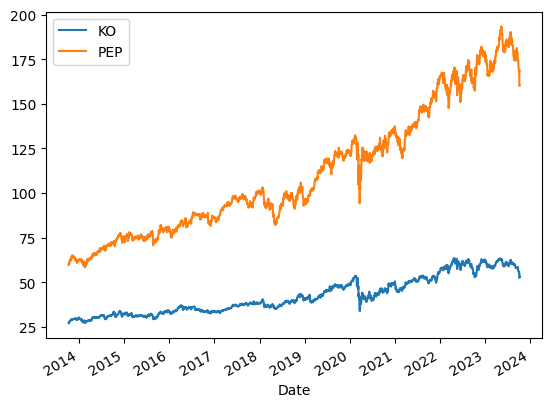

In [84]:
historical_data = historical_data.loc[:, 'Adj Close']
historical_data.plot()

In [85]:
corr_mat = (historical_data.pct_change().corr())
corr_mat

KO       PEP
KO   1.000000  0.738793
PEP  0.738793  1.000000

# Monte Carlo Simulation forecast

In [86]:
np.random.seed(1)

In [87]:
S0_ko = historical_data.iloc[-1, 0]  # using the last value
S0_pep = historical_data.iloc[-1, 1]  # using the last value
# sigma_ko = historical_data['KO'].pct_change().std()# using historical volatility
# sigma_pep = historical_data['PEP'].pct_change().std()# using historical volatility
# mu_ko = historical_data['KO'].pct_change().mean()# using historical average daily return
# mu_pep = historical_data['PEP'].pct_change().mean()# using historical average daily return

In [89]:
mu_ko = 0.0346
mu_pep = 0.0301
sigma_ko = 0.2705
sigma_pep = 0.4002

In [90]:
T = 1
NTrials = 1_000_000
# NTrials = 10000
# daily experiment
NSteps = 252
dt = T / NSteps
t = np.linspace(0, T, NSteps)

In [91]:
# we are only looking for 60 trading days
U_ko = np.random.uniform(size=(NTrials, 60))
U_pep = np.random.uniform(size=(NTrials, 60))
dW_ko = ss.norm.ppf(U_ko)
dW_pep = ss.norm.ppf(U_pep)

In [92]:
L = np.linalg.cholesky(corr_mat)

In [93]:
for i in range(NTrials):
    temp = np.stack([dW_ko[i], dW_pep[i]]).T @ L.T
    dW_ko[i], dW_pep[i] = temp[:, 0], temp[:, 1]

In [94]:
# confirm the correlation between two random number is 0.73
pd.DataFrame([dW_ko.reshape(-1)[:1000], dW_pep.reshape(-1)[:1000]]).T.corr()

0         1
0  1.000000  0.727013
1  0.727013  1.000000

In [95]:
# simulate the stock price using Geometric Brownian Motion
dS_ko = mu_ko * dt + sigma_ko * dW_ko * np.sqrt(dt)
dS_pep = mu_pep * dt + sigma_pep * dW_pep * np.sqrt(dt)
S_ko = S0_ko * np.cumprod(1 + dS_ko, axis=1)
S_pep = S0_pep * np.cumprod(1 + dS_pep, axis=1)

In [96]:
# # simulate the stock price using Arithmetic Brownian Motion
# dS_ko = mu_ko *dt+ sigma_ko * dW_ko 
# dS_pep = mu_pep *dt+ sigma_pep * dW_pep
# S_ko = S0_ko + np.cumsum(dS_ko, axis=1)
# S_pep = S0_pep + np.cumsum(dS_pep, axis=1)

In [97]:
def plot_simulations(arr, name, extra_plot=True):
    plt.figure(figsize=(20, 4))
    if extra_plot:
        plt.subplot(1, 3, 1)
        for sim in arr[:1000]:
            plt.plot(sim)
        plt.title(f'Simulation for {name}')
        plt.subplot(1, 3, 2)
        plt.plot(np.mean(arr, axis=0))
        plt.title(f'Mean for {name}')
        plt.subplot(1, 3, 3)
        plt.plot(np.std(arr, axis=0))
        plt.title(f'Standard Deviation for {name}')
        plt.show()
    else:
        for sim in arr:
            plt.plot(sim)
        plt.title(f'Simulation for {name}')
        plt.show()

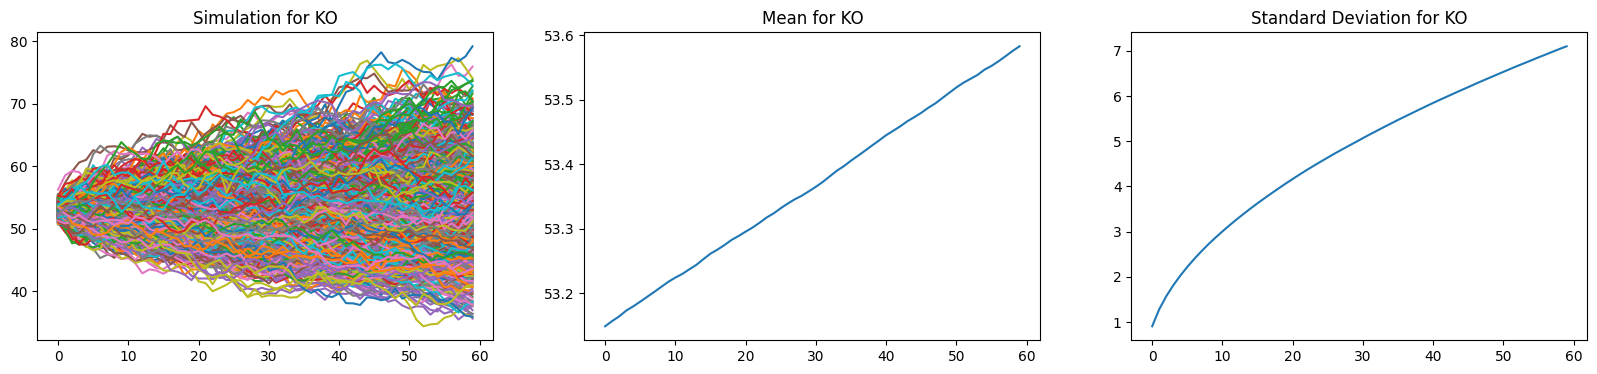

In [99]:
plot_simulations(S_ko, 'KO')

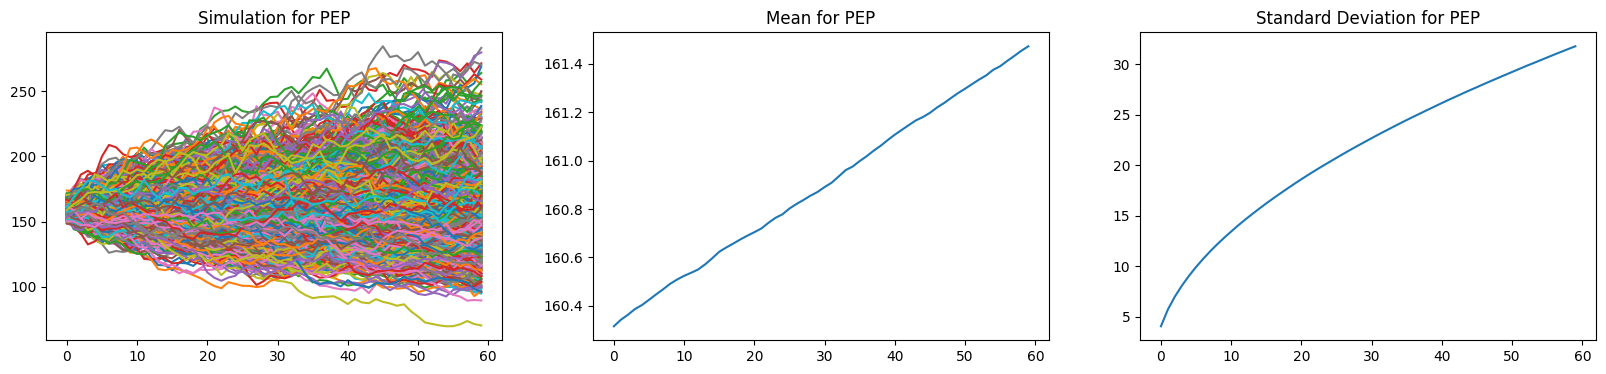

In [100]:
plot_simulations(S_pep, 'PEP')

In [101]:
spread = S_pep - S_ko

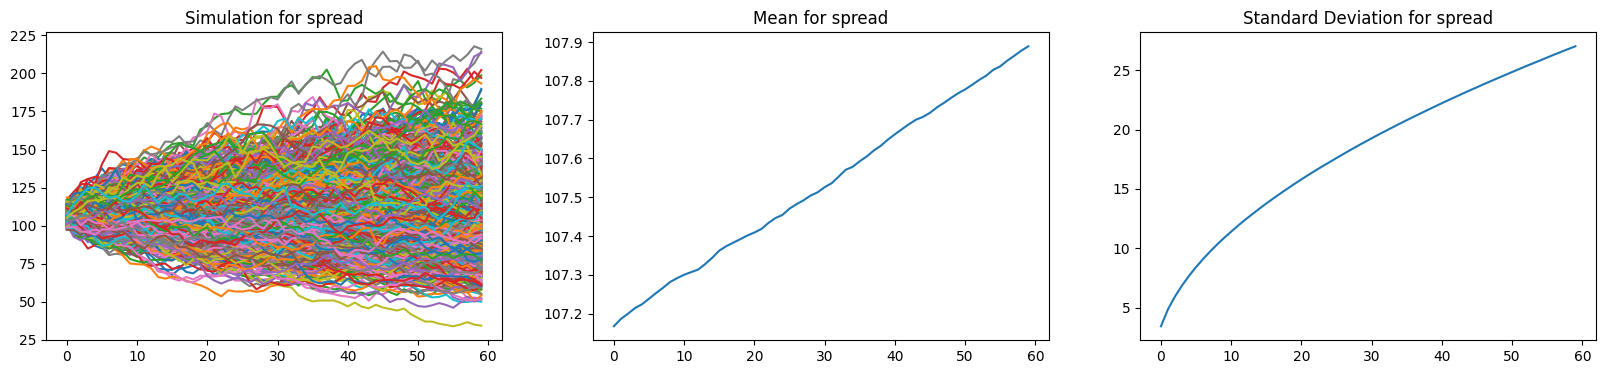

In [102]:
plot_simulations(spread, 'spread')

In [103]:
historical_spread = historical_data['PEP'] - historical_data['KO']

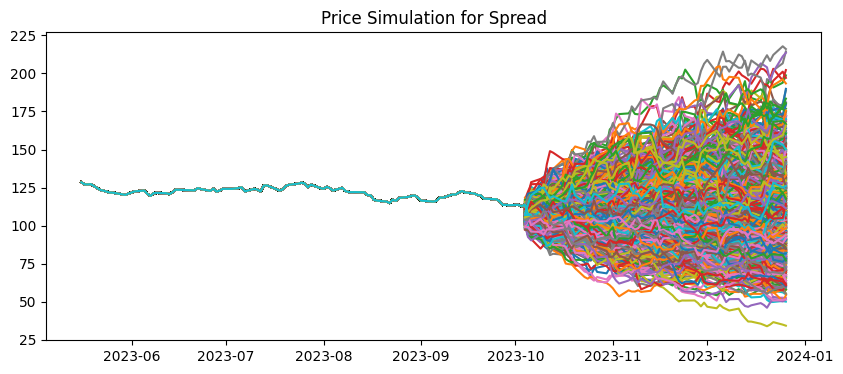

In [108]:
plt.figure(figsize=(10, 4))
for sim in spread[:1000]:
    temp = pd.concat([historical_spread[-100:], pd.Series(sim, index=pd.bdate_range('2023-10-04', periods=60))])
    plt.plot(temp)
plt.title('Price Simulation for Spread')
plt.show()

Text(0.5, 1.0, 'Confidence Interval for spread')

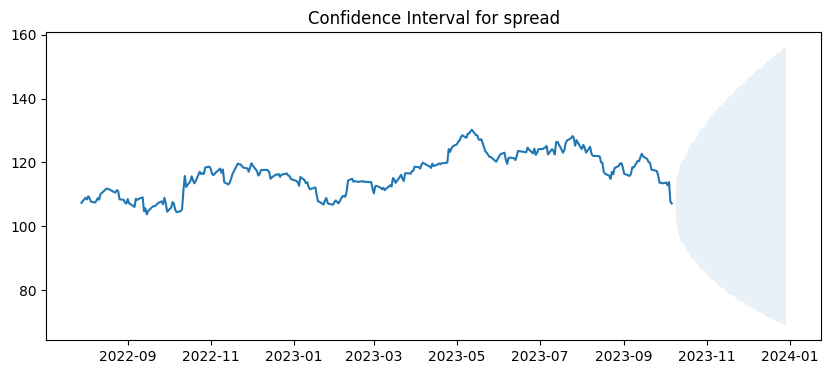

In [110]:
plt.figure(figsize=(10, 4))
# Plot the Confidence interval for the spread:
plt.plot(historical_spread[-300:])
# plt.plot(historical_spread)
plt.fill_between(pd.bdate_range('2023-10-09', periods=60), np.quantile(spread, 0.05, axis=0),
                 np.quantile(spread, 0.95, axis=0), alpha=0.1)
plt.title('Confidence Interval for spread')

# If we enter the trade on the 9th what is the expected value of the trade on the 16th?

### Assumptions: 
### 1. Assume no transaction cost, slippage, it is not hard for us to short coke, we trade on the close price of 9th October
### 2. Assume we can only buy stocks 100 shares at a time, and we can only short stocks 100 shares at a time (i.e. imperfect hedge)

In [111]:
num_short_pep = math.floor((100_000 / S0_pep) / 100) * 100
short_capital_gain = S0_pep * num_short_pep
num_long_ko = math.floor((short_capital_gain / S0_ko) / 100) * 100

In [112]:
print(f'number of PEP shares we short sell: {num_short_pep}')
print(f'amount of capital we have in short position: {num_short_pep * S0_pep}')
print(f'number of KO shares we long buy: {num_long_ko}')
print(f'amount of capital we have in long position: {num_long_ko * S0_ko}')
cash_reserve = num_short_pep * S0_pep - num_long_ko * S0_ko
print(f'cash reserve: {cash_reserve}')
long_pos = num_long_ko * S0_ko / (num_long_ko * S0_ko + num_short_pep * S0_pep+cash_reserve)
short_pos = num_short_pep * S0_pep / (num_long_ko * S0_ko + num_short_pep * S0_pep+cash_reserve)
cash_pos = cash_reserve / (num_long_ko * S0_ko + num_short_pep * S0_pep+cash_reserve)
print(f'percentage of capital we have in short pepsi position: {round(long_pos * 100, 2)}%')
print(f'percentage of capital we have in long coke position: {round(short_pos * 100, 2)}%')
print(f'percentage of capital we have in cash reserve: {round(cash_pos * 100, 2)}%')

number of PEP shares we short sell: 600
amount of capital we have in short position: 96173.99597167969
number of KO shares we long buy: 1800
amount of capital we have in long position: 95651.99890136719
cash reserve: 521.9970703125
percentage of capital we have in short pepsi position: 49.73%
percentage of capital we have in long coke position: 50.0%
percentage of capital we have in cash reserve: 0.27%


In [115]:
S0_ko

53.13999938964844

In [25]:
cash_ret_one_day = np.exp(0.05/365)-1

In [26]:
cash_ret_one_day

0.00013699568442171461

### Initial position
at October 9th,
we have long coke position: 1500 stock
we have short pepsi position: 500 stocks
cash reserve: 1529.9 dollar 

In [116]:
dS_cash = np.ones(dS_ko.shape) * cash_ret_one_day

In [117]:
position_return = long_pos * np.cumprod(1 + dS_ko, axis=1) - short_pos * np.cumprod(1 + dS_pep, axis=1)+cash_pos*np.cumprod(1+dS_cash, axis=1)

In [118]:
position_value = num_long_ko * S_ko - num_short_pep * S_pep + cash_reserve * np.cumprod(1 + dS_cash, axis=1)

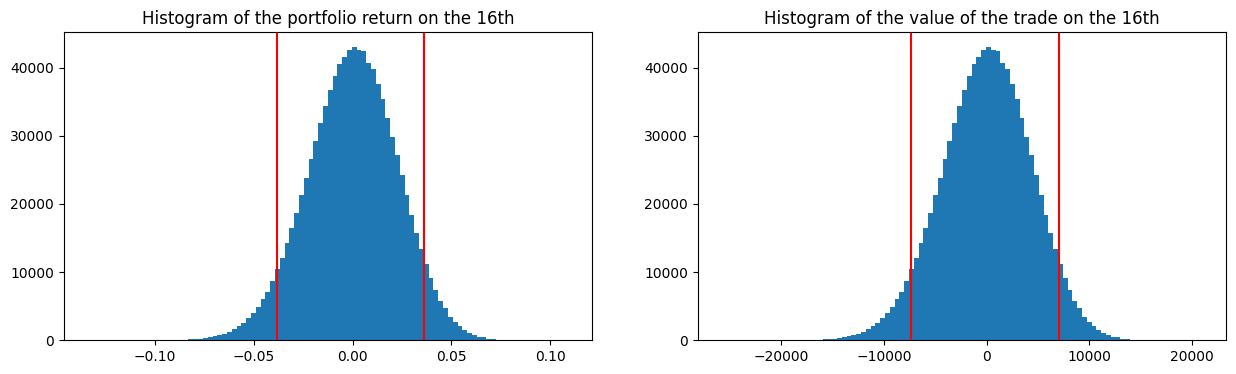

In [119]:
# the expected value of the trade on the 16th
plt.figure(figsize=(15, 4))
plt.subplot(1, 2, 1)
plt.hist(position_return[:, 6], bins=100)
plt.title('Histogram of the portfolio return on the 16th')
plt.axvline(np.quantile(position_return[:, 6], 0.05), color='r')
plt.axvline(np.quantile(position_return[:, 6], 0.95), color='r')
plt.subplot(1, 2, 2)
plt.hist(position_value[:, 6], bins=100)
plt.title('Histogram of the value of the trade on the 16th')
plt.axvline(np.quantile(position_value[:, 6], 0.05), color='r')
plt.axvline(np.quantile(position_value[:, 6], 0.95), color='r')

In [120]:
print(f'Expected value of the trade on the 16th: {np.mean(position_value[:, 6])}')
print(f'95th percentile profit-loss: {round(np.quantile(position_return[:, 6], 0.95) * 100, 3)}%')
print(f'5th percentile profit-loss: {round(np.quantile(position_return[:, 6], 0.05) * 100, 3)}%')

Expected value of the trade on the 16th: 3.65377761205551
95th percentile profit-loss: 3.639%
5th percentile profit-loss: -3.81%


In [121]:
np.mean(position_return[:,6])

1.8995662887556783e-05

# Answer for Position timing:
#### It is basically a mean-reversion trade: if we observe the spread > 1-alpha percentile spread, it is equivalent of saying we have a view that pepsi is too high relative to coke, we should short pepsi and long coke until the spread goes back to alpha percentile.
#### If we observe the spread < alpha percentile spread, it is equivalent of saying we have a view that pepsi is too low relative to coke, we should long pepsi and short coke until the spread goes back to alpha percentile.
#### when determine alpha, we should take consideration of the 5% annual return bank offers
# Pair Trading Strategy Simulation:
let's assume for simplicity that we can <b><u>enter the trade perfectly (i.e. we can long pepsi, short coke and net 0 portfolio values)</u></b>. we would enter the trade as described above.
## Trading Timing Assumptions:
we assume that at t=0, if we observe the spread move out of the alpha 1-alpha bound, we enter the trade
that means we don't trade t=0 (haven't observed the spread), and t=-1 (we don't know the spread return of t=-1)
so we calculate pct change of spread,then drop the first column
calculate trade direction, drop the last column 
<b><u>To simplify, we don't have transaction cost for portfolio rebalancing.</u></b>

# Pairs Trading Strategy Version 1: Simulate the spread using Geometric Brownian Motion of two correlated stocks

In [33]:
#60 days risk-free rate
(1+cash_ret_one_day)**60-1

0.008253048257775175

In [34]:
def strat_ret_fun(alpha,spread):
    short_spread = spread > np.quantile(spread, 1 - alpha, axis=0)
    long_spread = spread < np.quantile(spread, alpha, axis=0)
    short_spread = -short_spread.astype(int)
    long_spread = long_spread.astype(int)
    pos_direction = short_spread + long_spread
    pos_direction = pos_direction[:, :-1]# we ignore the final position because we don't have the corresponding spread return
    spread_ret = pd.DataFrame(spread).pct_change(axis=1).dropna(axis=1).values# drop the first day because we haven't been able to place the trade.
    strat_ret = np.cumprod(1 + (pos_direction * spread_ret), axis=1)
    return strat_ret


In [35]:
alpha_list = np.linspace(0.001, 0.1, 100)
mean_strat_ret_list = Parallel(n_jobs=-1)(delayed(np.mean)(strat_ret_fun(alpha,spread)[:,-1]) for alpha in tqdm(alpha_list))

100%|██████████| 100/100 [12:55<00:00,  7.75s/it]


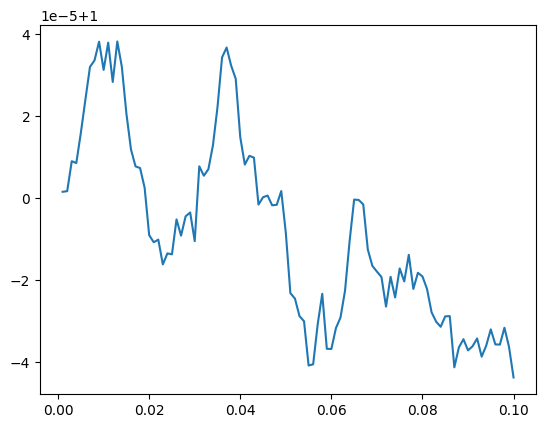

In [36]:
plt.plot(alpha_list, mean_strat_ret_list)

In [37]:
np.max(mean_strat_ret_list)

1.000038287613232

### <b><u>No one alpha is higher than the risk-free rate, which is what you would expect under EMH. For the sake of this exercise, We will use the alpha that maximizes the mean return</u></b>

In [38]:
alpha_list[np.argmax(mean_strat_ret_list)]# the alpha that maximize the expected return of the trade in 60 days

0.013000000000000001

In [40]:
strat_ret = strat_ret_fun(alpha_list[np.argmax(mean_strat_ret_list)],spread)

In [41]:
print(f'Expected value of the trade after three month: {np.mean(strat_ret[:, -1])}')

Expected value of the trade after three month: 1.000038287613232


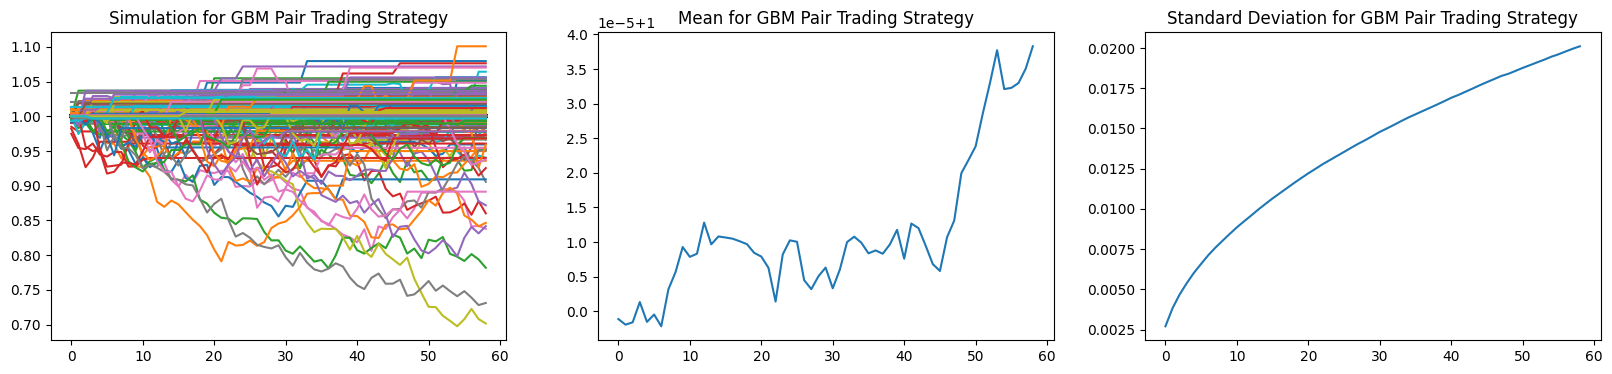

In [124]:
plot_simulations(strat_ret, 'GBM Pair Trading Strategy')

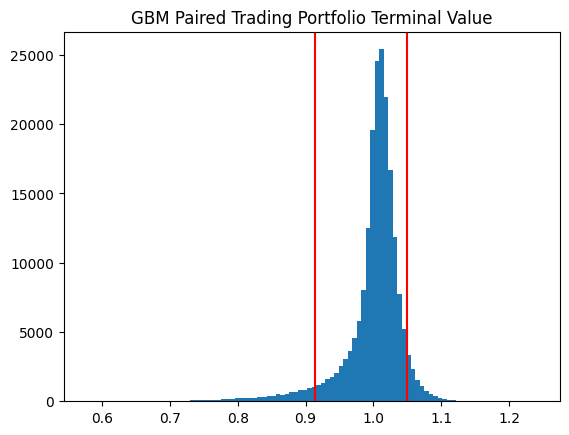

In [125]:
plt.hist(strat_ret[:, -1][np.where(strat_ret[:, -1] != 1)], bins=100)# we discard the 1 return because it distorts the histogram
plt.axvline(np.quantile(strat_ret[:, -1][np.where(strat_ret[:, -1] != 1)], 0.05), color='r')
plt.axvline(np.quantile(strat_ret[:, -1][np.where(strat_ret[:, -1] != 1)], 0.95), color='r')
plt.title('GBM Paired Trading Portfolio Terminal Value')
plt.show()

In [123]:
print(f'value at the 5th percentile: {(np.quantile(strat_ret[:, -1][np.where(strat_ret[:, -1] != 1)], 0.05)-1)*100}%')
print(f'value at the 95th percentile: {(np.quantile(strat_ret[:, -1][np.where(strat_ret[:, -1] != 1)], 0.95)-1)*100}%')

value at the 5th percentile: -8.629205468000379%
value at the 95th percentile: 4.966672381918236%


# Pairs Trading Strategy Version 2: Simulating the spread using Ornstein-Uhlenbeck process
Because the spread is mean-reverting process, we simulate the spread itself using OU process.
We first demonstrate that we can simulate historical spread using OU process, then we forecast the spread using OU process

## Part1: Simulating historical spread using OU process

In [186]:
NTrials = 100_000# the original number was too challenging for my computer. I have to reduce the number of trials

In [187]:
sTrend = historical_spread[0] + historical_spread.mean() * np.linspace(0, 1, len(historical_spread))

Text(0.5, 1.0, 'Spread minus trend')

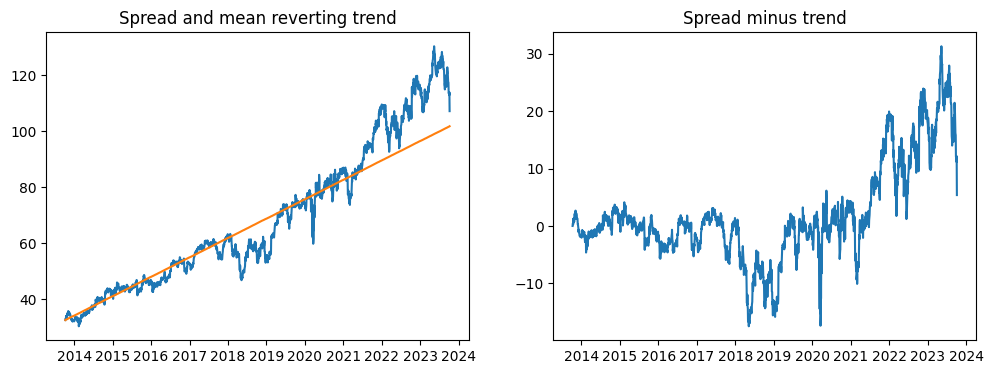

In [188]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(historical_spread)
plt.plot(pd.DataFrame(sTrend, index=historical_spread.index))
plt.title('Spread and mean reverting trend')
plt.subplot(1, 2, 2)
plt.plot(historical_spread - sTrend)
plt.title('Spread minus trend')

C:\Users\kevin\AppData\Local\Temp\ipykernel_6348\2754492560.py:4: MatplotlibDeprecationWarning: The 'use_line_collection' parameter of stem() was deprecated in Matplotlib 3.6 and will be removed two minor releases later. If any parameter follows 'use_line_collection', they should be passed as keyword, not positionally.
  plt.stem(range(len(acf)), acf, use_line_collection=True)


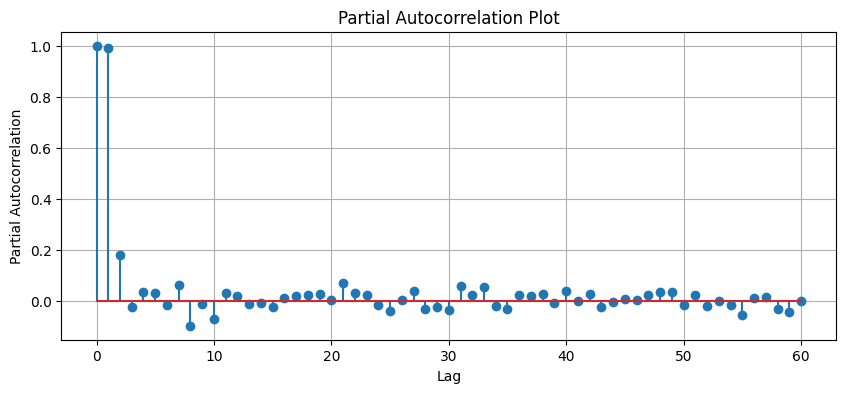

In [189]:
# partial autocorrelation plot
acf = sm.tsa.pacf(historical_spread - sTrend, nlags=60)
plt.figure(figsize=(10, 4))
plt.stem(range(len(acf)), acf, use_line_collection=True)
plt.xlabel('Lag')
plt.ylabel('Partial Autocorrelation')
plt.title('Partial Autocorrelation Plot')
plt.grid()
plt.show()

In [190]:
mu = (historical_spread - sTrend).mean()
sigma = (historical_spread - sTrend).std()

In [191]:
U = np.random.uniform(size=(10000, len(historical_spread)))
dW = ss.norm.ppf(U)
XOU = np.zeros(U.shape)
XOU[:, 0] = 0

In [192]:
a = 0.005# arbitrary defined

In [193]:
for i in range(1, len(historical_spread)):
    XOU[:, i] = XOU[:, i - 1] + a * (mu - XOU[:, i - 1]) * dt + sigma * dW[:, i] * np.sqrt(dt)

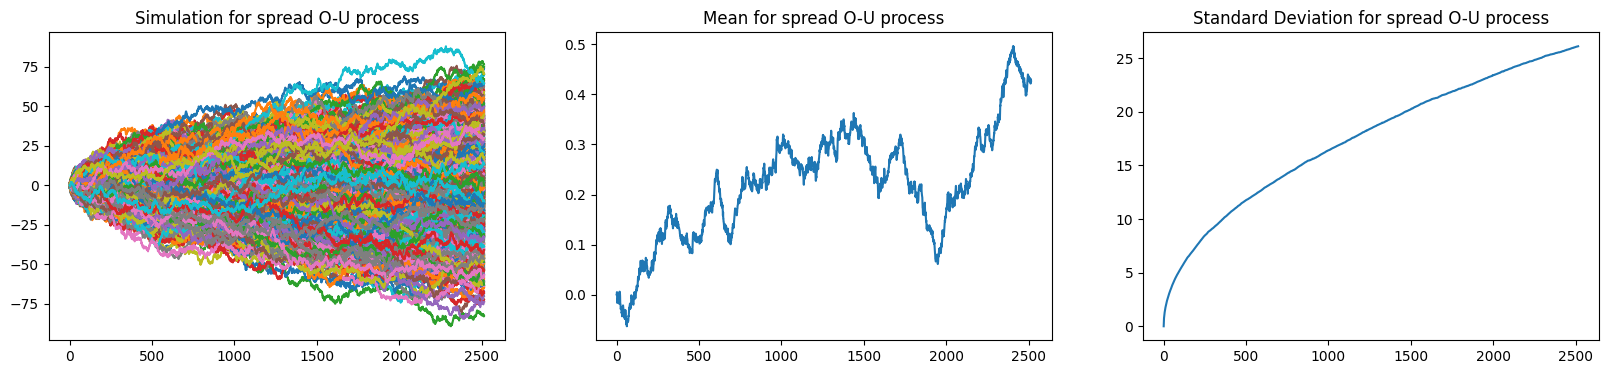

In [194]:
plot_simulations(XOU, 'spread O-U process')

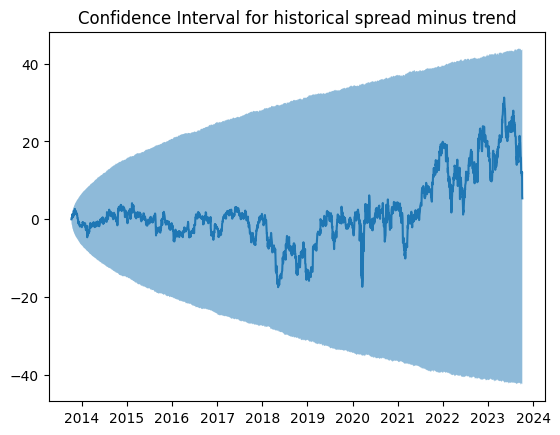

In [195]:
plt.plot(historical_spread - sTrend)
plt.fill_between(historical_spread.index, np.quantile(XOU, 0.05, axis=0), np.quantile(XOU, 0.95, axis=0), alpha=0.5)
plt.title('Confidence Interval for historical spread minus trend')
plt.show()

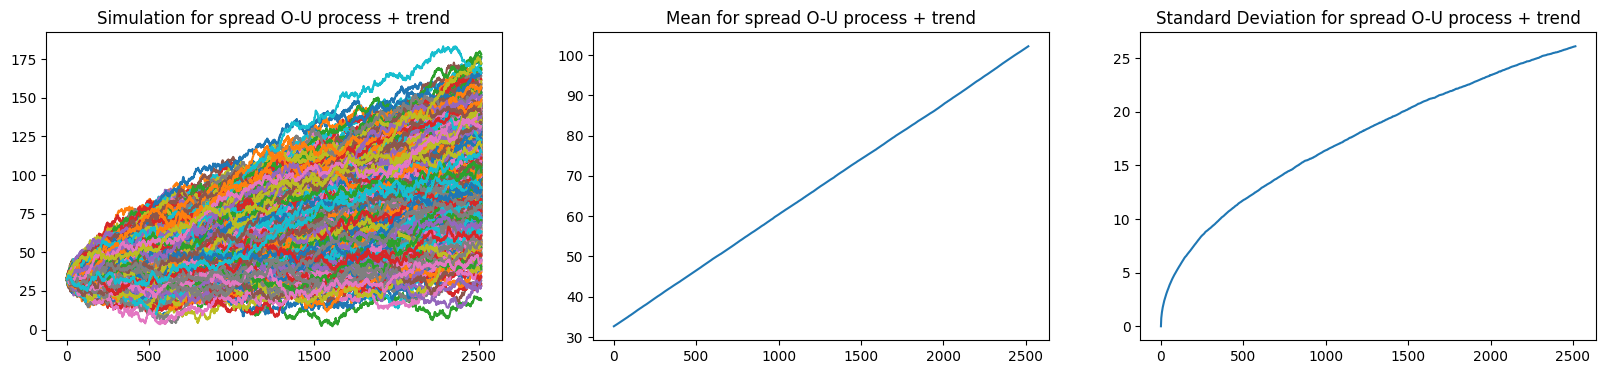

In [196]:
plot_simulations(XOU + sTrend, 'spread O-U process + trend')

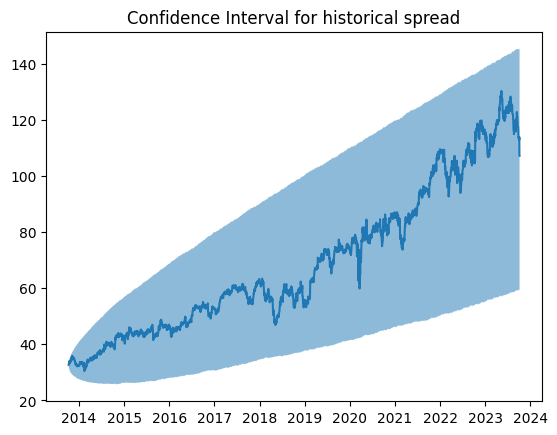

In [197]:
plt.plot(historical_spread)
plt.fill_between(historical_spread.index, np.quantile(XOU + sTrend, 0.05, axis=0),
                 np.quantile(XOU + sTrend, 0.95, axis=0), alpha=0.5)
plt.title('Confidence Interval for historical spread')
plt.show()

## Part 2: Forecasting the spread using OU process

In [198]:
sTrend_future = (historical_spread[0] + (historical_spread.mean() * np.linspace(0, 1, len(historical_spread)+60)))[len(historical_spread):]

In [199]:
mu = (historical_spread - sTrend).mean()
sigma = (historical_spread - sTrend).std()
U = np.random.uniform(size=(NTrials, 60))
dW = ss.norm.ppf(U)
XOU = np.zeros(U.shape)
XOU[:, 0] = 0
a = 0.005  # arbitrary defined
for i in range(1, 60):
    XOU[:, i] = XOU[:, i - 1] + a * (mu - XOU[:, i - 1]) * dt + sigma * dW[:, i] * np.sqrt(dt)

In [200]:
XOU = XOU + sTrend_future

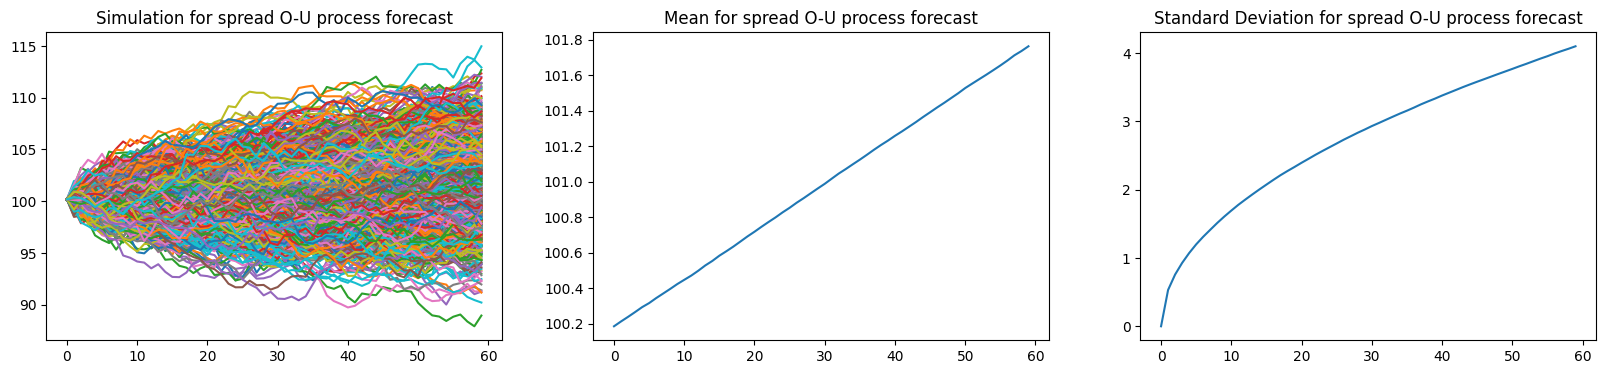

In [201]:
plot_simulations(XOU, 'spread O-U process forecast')

In [202]:
alpha_list = np.linspace(0.001, 0.5, 100)
mean_strat_ret_list = Parallel(n_jobs=-1)(delayed(np.mean)(strat_ret_fun(alpha,XOU)[:,-1]) for alpha in tqdm(alpha_list))

100%|██████████| 100/100 [01:02<00:00,  1.60it/s]


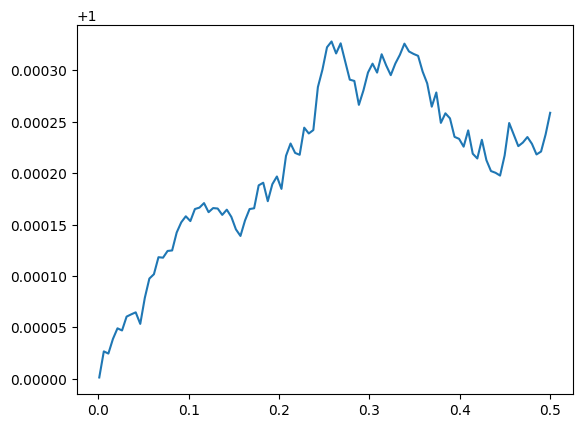

In [203]:
plt.plot(alpha_list, mean_strat_ret_list)

In [204]:
alpha_list[np.argmax(mean_strat_ret_list)]# the alpha that maximize the expected return of the trade in 60 days

0.25806060606060605

In [205]:
# use the alpha that maximize the expected return of the trade in 60 days
XOU_strat_ret = strat_ret_fun(alpha_list[np.argmax(mean_strat_ret_list)],XOU)

In [206]:
print(f'Expected value of the trade after three month: {np.mean(XOU_strat_ret[:, -1])}')

Expected value of the trade after three month: 1.0003280229705238


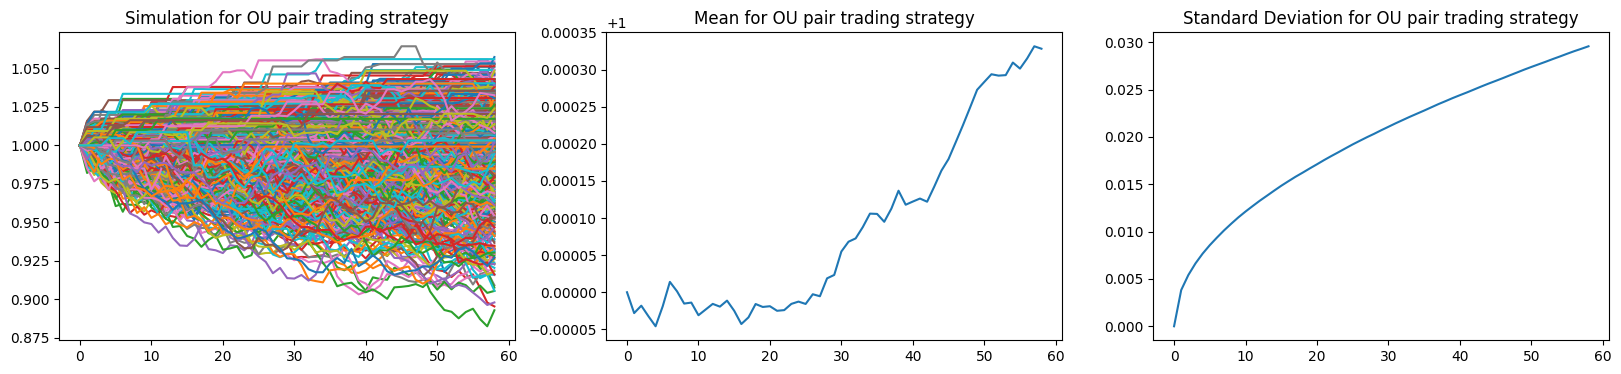

In [207]:
plot_simulations(XOU_strat_ret, 'OU pair trading strategy')

Text(0.5, 1.0, 'OU Process Paired Trading Portfolio Terminal Value')

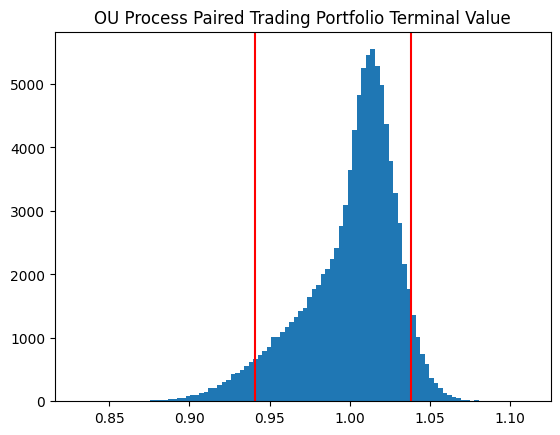

In [208]:
plt.hist(XOU_strat_ret[:, -1][np.where(XOU_strat_ret[:, -1] != 1)], bins=100)# we discard the 1 return because it distorts the histogram
plt.axvline(np.quantile(XOU_strat_ret[:, -1][np.where(XOU_strat_ret[:, -1] != 1)], 0.05), color='r')
plt.axvline(np.quantile(XOU_strat_ret[:, -1][np.where(XOU_strat_ret[:, -1] != 1)], 0.95), color='r')
plt.title('OU Process Paired Trading Portfolio Terminal Value')

# Pairs Trading Strategy Version 3: OU Process with correlation
Maybe we can generate dW term of the OU process using two correlated dw terms and minus each other. We first demonstrate that we can simulate historical spread using OU process with correlation, then we forecast the spread using OU process with correlation

## Part 1: Simulating Historical Spread using OU process with correlation

In [209]:
mu = (historical_spread - sTrend).mean()
sigma = (historical_spread - sTrend).std()
U1 = np.random.uniform(size=(NTrials, len(historical_spread)))
U2 = np.random.uniform(size=(NTrials, len(historical_spread)))
dW_1 = ss.norm.ppf(U1)
dW_2 = ss.norm.ppf(U2)
for i in range(NTrials):
    temp = np.stack([dW_1[i], dW_2[i]]).T @ L.T
    dW_1[i], dW_2[i] = temp[:, 0], temp[:, 1]
dW = dW_2 - dW_1
XOU = np.zeros(dW.shape)
XOU[:, 0] = 0
a = 0.005

In [210]:
for i in range(1, len(historical_spread)):
    XOU[:, i] = XOU[:, i - 1] + a * (mu - XOU[:, i - 1]) * dt + sigma * dW[:, i] * np.sqrt(dt)

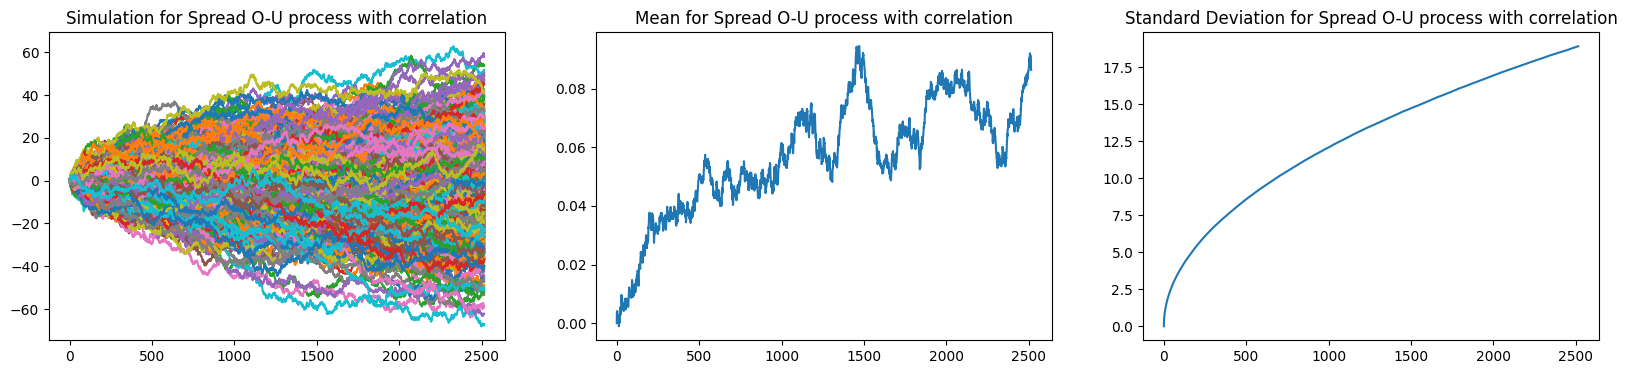

In [211]:
plot_simulations(XOU, 'Spread O-U process with correlation')

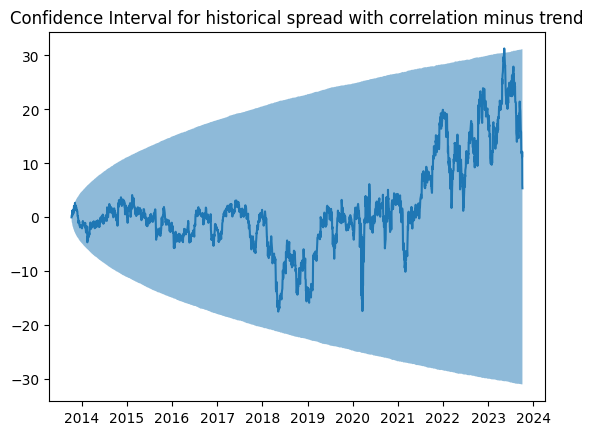

In [212]:
plt.plot(historical_spread - sTrend)
plt.fill_between(historical_spread.index, np.quantile(XOU, 0.05, axis=0), np.quantile(XOU, 0.95, axis=0), alpha=0.5)
plt.title('Confidence Interval for historical spread with correlation minus trend')
plt.show()

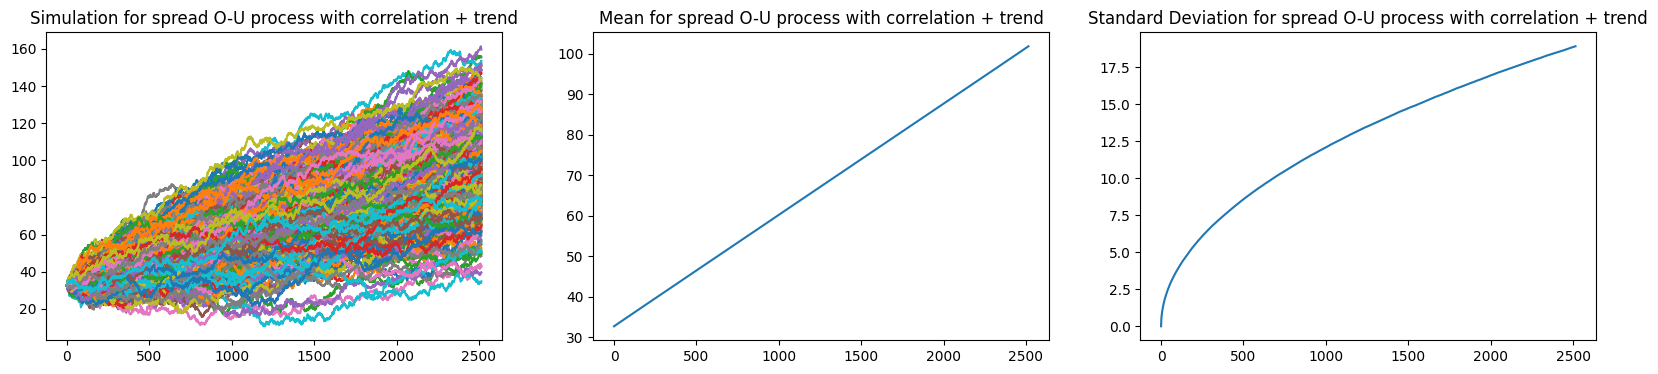

In [213]:
plot_simulations(XOU + sTrend, 'spread O-U process with correlation + trend')

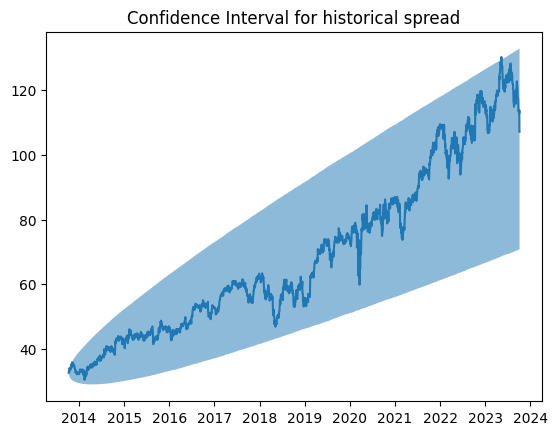

In [214]:
plt.plot(historical_spread)
plt.fill_between(historical_spread.index, np.quantile(XOU + sTrend, 0.05, axis=0),
                 np.quantile(XOU + sTrend, 0.95, axis=0), alpha=0.5)
plt.title('Confidence Interval for historical spread')
plt.show()

## Part2: Forecasting the spread using OU process with correlation

In [215]:
sTrend_future = (historical_spread[0] + (historical_spread.mean() * np.linspace(0, 1, len(historical_spread) + 60)))[
                len(historical_spread):]
mu = (historical_spread - sTrend).mean()
sigma = (historical_spread - sTrend).std()
U1 = np.random.uniform(size=(NTrials, 60))
U2 = np.random.uniform(size=(NTrials, 60))
dW_1 = ss.norm.ppf(U1)
dW_2 = ss.norm.ppf(U2)
for i in range(NTrials):
    temp = np.stack([dW_1[i], dW_2[i]]).T @ L.T
    dW_1[i], dW_2[i] = temp[:, 0], temp[:, 1]
dW = dW_2 - dW_1
XOU = np.zeros(dW.shape)
XOU[:, 0] = 0
a = 0.005  # arbitrary defined
for i in range(1, 60):
    XOU[:, i] = XOU[:, i - 1] + a * (mu - XOU[:, i - 1]) * dt + sigma * dW[:, i] * np.sqrt(dt)
XOU = XOU + sTrend_future

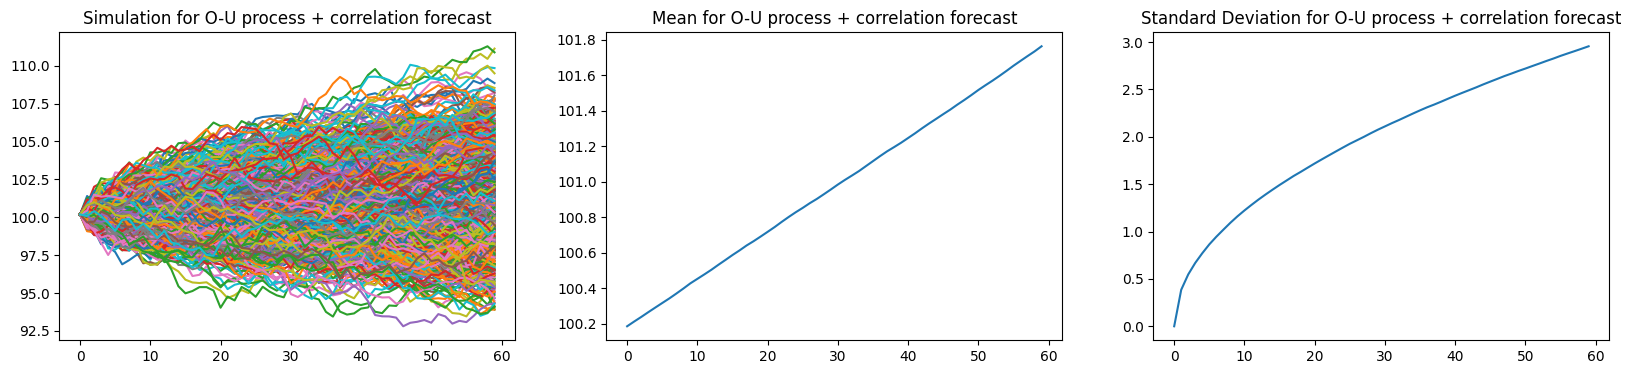

In [216]:
plot_simulations(XOU, 'O-U process + correlation forecast')

In [217]:
alpha_list = np.linspace(0.001, 0.5, 100)
mean_strat_ret_list = Parallel(n_jobs=-1)(delayed(np.mean)(strat_ret_fun(alpha, XOU)[:, -1]) for alpha in tqdm(alpha_list))

100%|██████████| 100/100 [01:02<00:00,  1.60it/s]


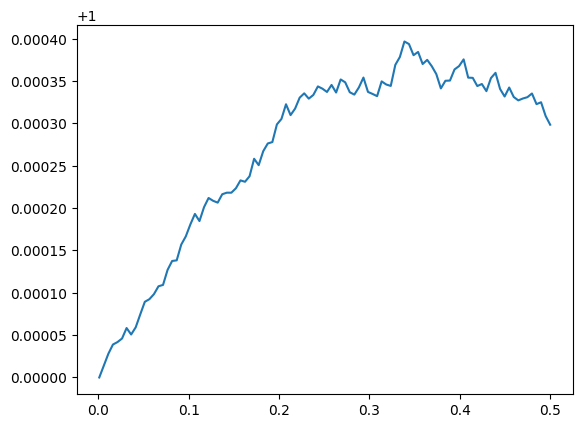

In [218]:
plt.plot(alpha_list, mean_strat_ret_list)

In [219]:
alpha_list[np.argmax(mean_strat_ret_list)]# the alpha that maximize the expected return of the trade in 60 days

0.33870707070707073

In [220]:
# use the alpha that maximize the expected return of the trade in 60 days
XOU_strat_ret = strat_ret_fun(alpha_list[np.argmax(mean_strat_ret_list)], XOU)

In [221]:
print(f'Expected value of the trade after three month: {np.mean(XOU_strat_ret[:, -1])}')

Expected value of the trade after three month: 1.0003965070963659


In [222]:
np.exp(0.05/4)# well, still hard to beat

1.0125784515406344

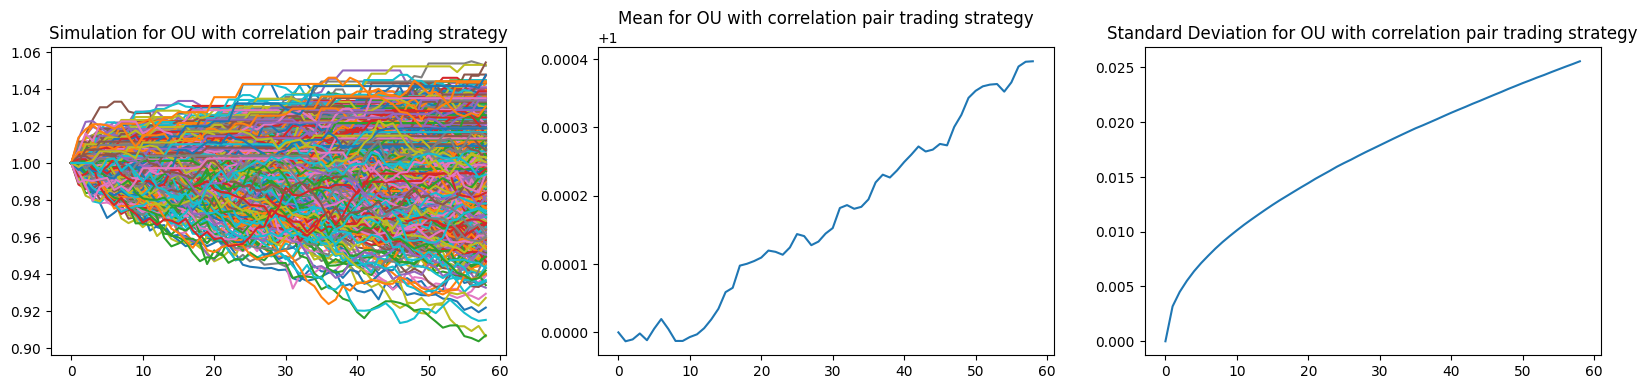

In [223]:
plot_simulations(XOU_strat_ret, 'OU with correlation pair trading strategy')

Text(0.5, 1.0, 'OU with correlation Paired Trading Portfolio Terminal Value')

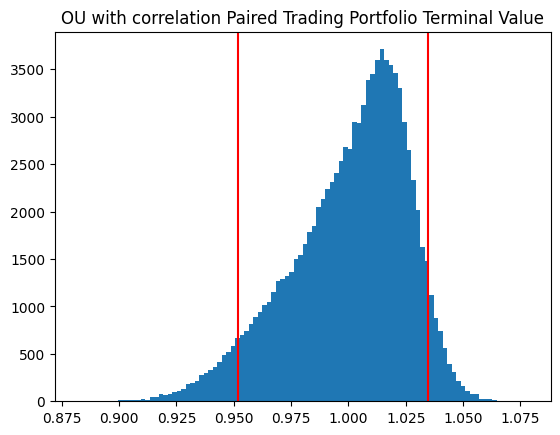

In [224]:
plt.hist(XOU_strat_ret[:, -1][np.where(XOU_strat_ret[:, -1] != 1)], bins=100)# we discard the 1 return because it distorts the histogram
plt.axvline(np.quantile(XOU_strat_ret[:, -1][np.where(XOU_strat_ret[:, -1] != 1)], 0.05), color='r')
plt.axvline(np.quantile(XOU_strat_ret[:, -1][np.where(XOU_strat_ret[:, -1] != 1)], 0.95), color='r')
plt.title('OU with correlation Paired Trading Portfolio Terminal Value')
